In [2]:
# home team         away team                                    season,datetime,referee
# fthg-predict      ftag-predict        **ftr-sanity check
# hthg              htag                **half time result
# hs                as
# hst               ast
# hc                ac
# hf                af
# hy                ay
# hr                ar  
# ftr_num
# htr-num

In [3]:

%load_ext autoreload
%autoreload 2

## Feature eng

In [4]:
import pandas as pd 
data_path=r"epl_23-f.csv"
data=pd.read_csv(data_path,encoding='windows-1254')
data.columns=[i.lower() for i in data.columns]
data.datetime=pd.to_datetime(data.datetime).dt.date  # dates were in string format do converted to datetime format/some variant
data.drop(data.loc[data['season'].str.contains('1993|1994|1995|1996|1997|1998|1999',regex=True)].index,inplace=True) #contains null values
# always make them in this order  to keep the ordering a constant
data.sort_values(['datetime','hometeam','awayteam','referee'],ascending=True,inplace=True) #this be the unique order
data.reset_index(drop=True,inplace=True) #and resetting index to make it starting from zero again
# no matter what happens i always want the above code to be running
# ammona keep this in mind ammona make this all features as i am predicting just one thing which is full time results-ftr


def transform1(data):
    """some tranasformations and features"""
    points_h_map={'H':3,'D':1,'A':0}
    points_a_map={'H':0,'D':1,'A':3}
    data['hp']=data['ftr'].map(points_h_map)
    data['ap']=data['ftr'].map(points_a_map)
    # win_map={'H':0,'D':1,'A':2}
    # data['ftr_num']=data['ftr'].map(win_map) #point home team got in that match
    # data['htr_num']=data['htr'].map(win_map) #points awa team got in that match
    return data
data=transform1(data)

In [5]:
columns_to_sort_by=data.select_dtypes('object').drop(['season','ftr','htr'],axis=1).columns.tolist()
columns_to_taransform=data.select_dtypes(include=['float64','int64']).columns.tolist()


In [6]:
# (data.groupby('datetime',as_index=False)['referee'].value_counts()['count']!=1).sum()
object_d=list(data.select_dtypes('object').drop(['hometeam','awayteam'],axis=1).columns) #[:7]
# int_d=['ftr_num','htr_num'] #[7:9]
home=['hometeam','fthg','hthg','hs','hst','hc','hf','hy','hr','hp'] #[9:18]-2
away=['awayteam','ftag','htag','as','ast','ac','af','ay','ar','ap'] #[18:]-2
data=data.reindex(columns=object_d+home+away)   #**very important data -the base data

import numpy as np
home_data=data[object_d+home]# data with only home attributes
away_data=data[object_d+away] #data with only away attributes
original_features_names=['ftg','htg','s','st','c','f','y','r','p']

In [7]:
# rolling home and away combined
def rol_hac(home_data,away_data):
    """making a rolling of all attributes representing a team offense"""

    away_data.columns=object_d+home #changed away to look like home
    combined_data=pd.concat([home_data,away_data],ignore_index=True)#cancatted it
    combined_data['identification']=np.array([np.ones(home_data.shape[0]),np.zeros(home_data.shape[0])],dtype=np.int64).reshape(-1,1)#making an identifier to split later
    # combined data-very important its data raveled vertically
    
    rol_hac=pd.DataFrame(index=combined_data.index)
    features_to_rol=home[1:]
    for col in features_to_rol:
        feature=combined_data.groupby('hometeam',as_index=False)[col].rolling(window=10,center=True,min_periods=5).mean().shift(1).fillna(method='bfill')[col]
        rol_hac[col]=feature
    home_df=rol_hac[combined_data.identification==1]
    away_df=rol_hac[combined_data.identification==0].reset_index(drop=True)
    home_df.columns=[i+'_hr'for i in original_features_names] #hr-home rolling but its offencive
    away_df.columns=[i+'_ar'for i in original_features_names] #away rolling but offencive
    rol_features=home_df.join(away_df) #suffixes are for overlapping columns
    return rol_features

def rol_hac_d(home_data,away_data):
    """this features are rolling home and away combined attributes(attributes like home shots,home fouls away yellow acrds etc )
    conceded by home and away teams until the previous match
    hs_c=shots conceded by the  home team until the previous match
    ha_c=shots conceded by the away team until the previous match ,i think you get the idea
    """
    
    home_data.columns=object_d+away #changed away to look like home
    combined_data=pd.concat([away_data,home_data],ignore_index=True)#cancatted it
    combined_data['identification']=np.array([np.ones(home_data.shape[0]),np.zeros(home_data.shape[0])],dtype=np.int64).reshape(-1,1)#making an identifier to split later
    # ones represent what is home teams defence and zeros represent away teams defence
   
    rol_hac=pd.DataFrame(index=combined_data.index)
    features_to_rol=away[1:]
    for col in features_to_rol:
        feature=combined_data.groupby('awayteam',as_index=False)[col].rolling(window=10,center=True,min_periods=5).mean().shift(1).fillna(method='bfill')[col]
        rol_hac[col]=feature # c indicates conceded
    home_df=rol_hac[combined_data.identification==1]
    home_df.columns=[i+'_chr'for i in original_features_names] #-chr-conceded home rolling
    away_df=rol_hac[combined_data.identification==0].reset_index(drop=True)
    away_df.columns=[i+'_car'for i in original_features_names] #-car-conceded away rolling
    rol_features=home_df.join(away_df)
    return rol_features

In [8]:
rollin_features=rol_hac(home_data.copy(),away_data.copy())
# rolling features are rolling attributes of team when they were home and away combined

rollin_features_d=rol_hac_d(home_data.copy(),away_data.copy())
# rolling_features_d are rolling attributes conceded by teams when they were home and away, combined

In [9]:
ob_data=data.select_dtypes('object')
new_data=ob_data.join([rollin_features,rollin_features_d])

import preprocessing
new_data2=preprocessing.season_datetime_fix(new_data.copy())

import datetime as dt
new_data2[['dayofseason','week','day']]=new_data2[['dayofseason','week','day']].astype('int64')

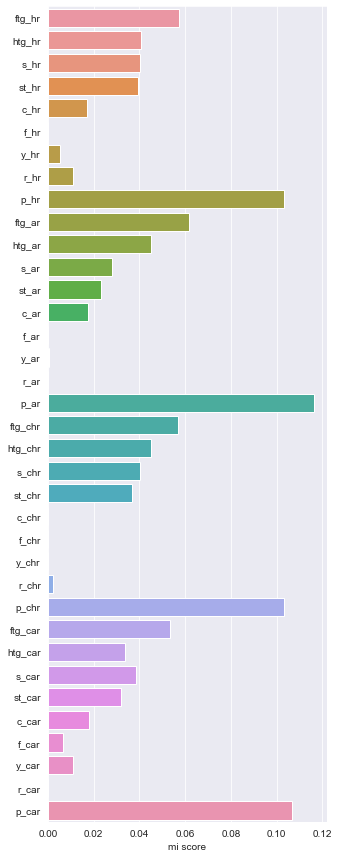

In [10]:
def mi(new_data):
    from sklearn.feature_selection import mutual_info_classif
    pp=new_data.select_dtypes('number')
    tx=new_data2['ftr']
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()
    tx=le.fit_transform(tx)
    mi=mutual_info_classif(pp,tx)
    
    import seaborn as sns
    sns.set_style('darkgrid')
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5,15))
    mi=pd.DataFrame(mi,index=pp.columns,columns=['mi score'])
    mi.sort_values('mi score',ascending=False)
    sns.barplot(mi['mi score'],mi.index);
mi(new_data)

In [22]:
import warnings
warnings.simplefilter('ignore')
import preprocessing
import features
import optimization
import utility
import models
class train:
      def __init__(self,new_data):
            self.new_data=new_data
      def f1(self):
            train,test=utility.splits(self.new_data,test_size=0.1)
            train,val=utility.splits(train,test_size=0.1)
            trainx,trainy=features.train_test_split(train)
            valx,valy=features.train_test_split(val)
            testx,testy=features.train_test_split(test)
            param_space=optimization.randf_clf_params
            model=models.pipeline_rfclf
            bayes = optimization.bayes_estimation(
            param_space, trainx, trainy, valx, valy, model, False)
            parameters = bayes.parameters(multi=False)
            parameters = optimization.format_result(parameters)
            model = model[-1].set_params(**parameters)
            return model,trainx,trainy,valx,valy,testx,testy
      def f2(self):
            model,trainx,trainy,valx,valy,testx,testy=self.f1()
            model.fit(trainx,trainy)
            tr_preds=model.predict(trainx)
            vl_preds=model.predict(valx)
            ts_preds=model.predict(testx)
            return models.Train.single_out(tr_preds,trainy),models.Train.single_out(vl_preds,valy),models.Train.single_out(ts_preds,testy)


training=train(new_data)
a,b,c=training.f2()

100%|██████████| 10/10 [00:15<00:00,  1.55s/trial, best loss: 0.5911528150134048]


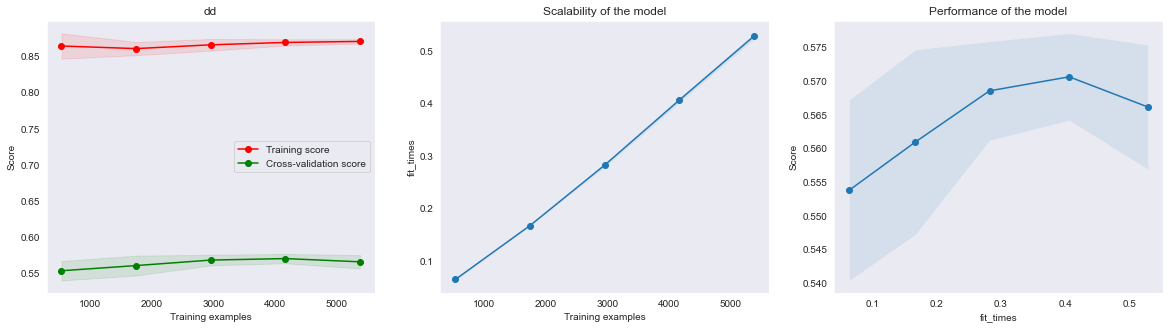

In [42]:
curve=utility.plot_learning_curve(estimator=model,X=trainx,y=trainy,title='dd')